# Classification

## Intro

As you should know by now, most tasks can be either defined as regression (predicting a continuous value) or classification (predicting a discrete value) problems.

The simplest form of a classification problem is __binary classification__:

> Special case of classification, where our targets (values to predict) can either take value `0` or `1`.

`cat` vs `dog` is an example, where `cat=0` and `dog=1`. That is, every example has a label which is either `True` or `False`.

See below for an example:

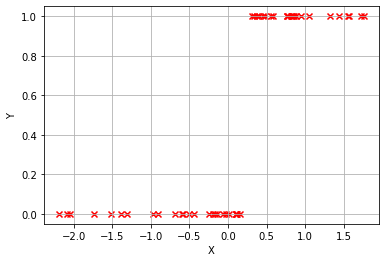

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def make_binary_data(m=50): 
    X = np.random.randn(m) #sample from a normal distribution
    X = np.array(sorted(X))
    Y = X > 0.2    # return binary vector with true where X above some threshold and false if below
    return X, Y #returns X (the input) and Y (labels)

def plot_data(X, Y):
    plt.figure()
    plt.scatter(X, Y, c='r', marker='x')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.show()
    
X, Y = make_binary_data()
plot_data(X, Y)

Previously, the output of our model could be any real number, negative or positive, unbounded in magnitude. Here the thing is a little more involved.

> In classification, we can interpret the model output as a confidence that the example belongs to a particular class.

Which bring us to...

## Logits

> vector (in binary case a scalar) of unnormalized probabilities in the range $(-\infty, \infty)$

Maybe you've noticed it is __exactly what we've been outputting with regression__!

You know what probability is, so logits are pretty similar, but:
- __50% chance (probability=$0.5$) is equal to logit=$0$__
- Anything below zero is less probable, anything above more

Logits are used for classification in order to:
- not making unnecessary operation transforming them into probabilities if we are after label (we will see the transformation shortly)
- for binary classification every output from our classifier which is greater than `1` is considered `True`, anything below is `False`

__Note:__ mathematically, the term logit refers to the log of the odds of a probability and __transforms probability (p below) back into $(-\infty, \infty)$ range__.
It can be written by the following formula:

$$
    L = \ln \frac{p}{1 - p}
$$

However, we will use the term logit later to simply refer to the values outputted by the model.

## From logits to probabilities

We can do this by applying a **sigmoid** function to our output:

![](images/sigmoid.jpg)

> sigmoid squashes logits from $(-\infty, \infty)$ to $(0, 1)$ range which we can easily interpret

We can also write a function to compute the derivative of the sigmoid function.
We will need this to differentiate our loss with respect to the model parameters, as they only affect the loss through the sigmoid.

__Note:__ Sigmoid is the inverse function of logit

![](images/sigmoid_deriv.jpg)

## Exercise

Let's implement our sigmoid `class` and `sigmoid` function in code. We will code it as and `g.Operation`  as it was done up to this point:

In [2]:
import aicore.ml.graph as g

class _Sigmoid(g.Operation):
    def forward(self, inputs):
        self.cache = 1 / (np.exp(-inputs) + 1)
        return self.cache

    def backward(self, upstream_gradient):
        return upstream_gradient * self.cache * (1 - self.cache)


def sigmoid(inputs):
    return _Sigmoid()(inputs)

Let's see what happens when we input some values:

In [3]:
print(
    sigmoid(np.array([-0.5, 0.5, 0])),
    sigmoid(np.array([-3, 1, 1])),
    sigmoid(np.array([-100, 100])),
    sigmoid(np.array([1000000, 0])),
    sep="\n",
)

[0.37754067 0.62245933 0.5       ]
[0.04742587 0.73105858 0.73105858]
[3.72007598e-44 1.00000000e+00]
[1.  0.5]


But there is one input which destroys our function...

In [4]:
sigmoid(np.array([-1000]))

<ipython-input-2-7632d6b793a5>:5: RuntimeWarning: overflow encountered in exp
  self.cache = 1 / (np.exp(-inputs) + 1)


array([0.])

## Analysis

What happened, why did we get an error? Value of `np.exp` grows exponentially and `double` (`float64`) type cannot keep such large numbers in memory.

Let's check what is the maximum `value` one can pass into `exp(value)` function:

In [5]:
# Get maximum double value in numpy
max_double = np.finfo("d").max
max_value_to_exp = np.log(max_double)

print(f"maximum value: {max_value_to_exp}")
print(f"exp(maximum value): {np.exp(max_value_to_exp)}")

# Get epsilon value for double
print(
    "\nOUTPUT BELOW AS A NON-ML ADDITIONAL CHALLENGE TO SOLVE\n",
    "See Challenges at the end\n",
)
epsilon = np.finfo("d").eps
print(f"double epsilon: {epsilon}")
print(
    "exp(maximum value + 255 * epsilon) == exp(maximum value): {}".format(
        np.exp(max_value_to_exp + 255 * epsilon) == np.exp(max_value_to_exp)
    )
)
print(f"exp(maximum value + 255*epsilon): {np.exp(max_value_to_exp + 255*epsilon)}")
print(f"exp(maximum value + 256*epsilon): {np.exp(max_value_to_exp + 256*epsilon)}")

maximum value: 709.782712893384
exp(maximum value): 1.7976931348622732e+308

OUTPUT BELOW AS A NON-ML ADDITIONAL CHALLENGE TO SOLVE
 See Challenges at the end

double epsilon: 2.220446049250313e-16
exp(maximum value + 255 * epsilon) == exp(maximum value): True
exp(maximum value + 255*epsilon): 1.7976931348622732e+308
exp(maximum value + 256*epsilon): inf


<ipython-input-5-d164304c9247>:21: RuntimeWarning: overflow encountered in exp
  print(f"exp(maximum value + 256*epsilon): {np.exp(max_value_to_exp + 256*epsilon)}")


Natural logarithm $\ln$ (`np.log` in `numpy`) is inverse of `exp`, hence we can get the maximum this way which is around `709` for double (default) type.

__Note:__ `epsilon` is the smallest change which is registered by type. See challenges at the end for more info, this one will be additional (https://en.wikipedia.org/wiki/Octuple-precision_floating-point_format).

So, how can we solve the overflow issue?

## Stable sigmoid

`sigmoid` formula can be written as:

$$
    S(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{1 + e^{x}}
$$

Our previous implementation explodes __only when the value is large (`709`) and negative__. That is because the negative sign is inverted with `-z` and we get positive `709`. Given this:

- $e^x$ will overflow when $x$ is positive
- $e^{-x}$ will overflow when $x$ is negative

This leads us to another exercise...

## Exercise

Implement stable version of sigmoid. We will use two `helper` functions:
- `_negative_sigmoid` - used when values passed as `inputs` are `negative`
- `_positive_sigmoid` - used when values passed as `inputs` are `positive`

Formulas are provided above, that's the only two functions you have to implement.

__Read `sigmoid` code and make sure you understand what is going on and why!__ (you can read [this stackoverflow answer](https://stackoverflow.com/a/64717799/10886420) for in-depth explanation, but that's optional)

In [6]:
def _negative_sigmoid(inputs):
    # Second formula for negative values
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(inputs)
    return exp / (exp + 1)


def _positive_sigmoid(inputs):
    # First formula for positive values
    return 1 / (1 + np.exp(-inputs))


def sigmoid(inputs):
    positive = inputs >= 0
    # Boolean array inversion is faster than another comparison
    negative = ~positive

    # empty contains junk hence will be faster to allocate than zeros
    result = np.empty_like(inputs)
    result[positive] = _positive_sigmoid(inputs[positive])
    result[negative] = _negative_sigmoid(inputs[negative])
    return result

This version should work correctly for all of the cases below

In [7]:
print(
    sigmoid(np.array([-0.5, 0.5, 0])),
    sigmoid(np.array([-3, 1, 1.])),
    sigmoid(np.array([-100., 100.])),
    sigmoid(np.array([1000, 0])),
    sigmoid(np.array([-1000])),
    sep="\n",
)

[0.37754067 0.62245933 0.5       ]
[0.04742587 0.73105858 0.73105858]
[3.72007598e-44 1.00000000e+00]
[1 0]
[0]


## The loss function for binary classification-  Binary cross entropy (BCE)

Basic formula for BCE is:

$$
    BCE = - (y\ln\hat{y} + (1-y)\ln(1-\hat{y}))
$$

We can break it down into parts exclusively:
- if the label is `1` $(1-y)\ln(1-\hat{y})$ is `0`
- if the label is `0` $y\ln\hat{y}$ is `0`

![](./images/bce.jpg)

### Why not calculate only one part per label?

Can't we calculate one part for `1` label and the second for `0` label with some kind of `if label == 0` switch? Yes, we could, but sometimes in machine learning & deep learning we use technique called `label smoothing`...

## Label smoothing

> Label smoothing changes `{0, 1}` labels into "soft targets", for example `{0.1, 0.9}`

### Why would we do that?

- It is impossible to reach `1` value for sigmoid in practice. Hence, even if our predicted probability is `0.99999` we will still have some loss left
- Same thing happens for `0` as it is really hard for the classifier to reach exactly this value

### How to do that?

- there are many implementations. Usually we subtract from largest labels (`1`) some constant and add it to `0` labels (for binary case)
- $\alpha$ is our __smoothing hyperparameter__, usually around `0.1`

### How does it help?

- Our classifier is __less confident__ about it's predictions. Due to inherit noise in data it is often desirable (especially for the more complex and powerful models, yes, neural networks are prime example)
- Predictions are more smooth and gradual. Instead of having rough jumps from `0.999` probability to `0.0001` probability in another case, our algorithms try to distribute the probability more evenly
- Classifier __does not try to "be sure" about hard examples so much__. As it has to reach `0.9` (let's say) instead of `1`, `0.8` will be also fine

## Binary Cross Entropy implementation

Let's start with naive implementation, simply follow the formula:

In [8]:
def bce(prediction, label):
    return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))

In [9]:
prediction = sigmoid(np.array([-0.5, 0.5, 0])) 
labels = np.array([0, 1, 1])

print(bce(prediction, labels))

[0.47407698 0.47407698 0.69314718]


But as usual, __numerical instability creeps in__. As a rule of thumb, always look suspicious at `exp` and it's inverse function `ln`:

In [10]:
prediction = np.array([1])
labels = np.array([0])

print(bce(prediction, labels))

[inf]


<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [11]:
prediction = np.array([0])
labels = np.array([1])

print(bce(prediction, labels))

[inf]


<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [12]:
prediction = np.array([0])
labels = np.array([0])

print(bce(prediction, labels))

[nan]


<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))
<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: invalid value encountered in multiply
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


In [13]:
prediction = np.array([1])
labels = np.array([1])

print(bce(prediction, labels))

[nan]


<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: divide by zero encountered in log
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))
<ipython-input-8-f3031382e7cc>:2: RuntimeWarning: invalid value encountered in multiply
  return -(label * np.log(prediction) + (1 - label) * np.log(1 - prediction))


### Analysis

- if our model __is very condfident and IS WRONG__ (first two cases) we are left with  `np.log(0)` (which goes towards $-\infty$, when we take `-` it is simply $\infty$ we observe). 
- if our model __is very condfident and IS RIGHT__ (last two cases) we will be left with $ 0 * \ln{0} $, hence with $ 0 * \infty $ which is undefined `NaN` (not a number)

Can we improve it somehow?

## Stable BCE

To stabilize binary cross entropy loss we can mix activation we saw earlier (`sigmoid`) and `binary cross entropy` itself.

### Formulation

One can derive numerically stable version. It takes some math so a few steps are skipped. You can see the formula that we will use [here](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits):

$$
\begin{align}
    BCE & = - (y\ln\hat{y} + (1-y)\ln(1-\hat{y})) \\
        & = - (y\ln(\frac{1}{1+e^{-x}}) + (1-y)\ln(1-\frac{1}{1+e^{-x}}) \\
        & ... \\
        & = x - xy + \ln(1 + e^{-x})
\end{align}
$$

Unfortunately this leaves us with $e^{-x}$ once again. After a few math tricks we come to this formula (really, go through it yourself to see some beautiful math tricks):

$$
    \max(0, x) - xy + \ln(1 + e^{-|x|})
$$

where `x` are logits, `y` are labels

You can see no matter the `x` value it will always be negative so `e` can only underflow which is fine for our case (and $\ln(1 + 0) = 0$). There are also [other formulas](https://discuss.pytorch.org/t/numerical-stability-of-bcewithlogitsloss/8246) but we won't go into details.

### Derivative

We also have to calculate derivative of `BCEWithLogits` to backpropagate through our model.

It is a little cumbersome, but remember you can always use [Wolfram Alpha](https://www.wolframalpha.com/) for such tasks (or it will get you some idea or direction at least).

Given that, the derivative is presented as:

$$
\begin{align}
    \frac{\partial BCE}{\partial x} &= \sigma(x) - y \\
    \frac{\partial BCE}{\partial y} &= -x
\end{align}
$$

## Exercise

__Implement stable binary cross entropy with logits__

- Formula for `forward` and `backward` was already provided
- Use `sigmoid` (the stable version) in your implementation of `backward`!
- Name the function `bce_with_logits` (and name `class` appropriately according to [`PEP8`](https://www.python.org/dev/peps/pep-0008/) standard)

__This binary cross entropy will work directly on `logits`__

In [14]:
class _BCEWithLogits(g.Operation):
    def forward(self, logits, targets):
        self.cache = (logits, targets)
        return (
            np.maximum(np.zeros_like(logits), logits)
            - logits * targets
            + np.log(1 + np.exp(-np.abs(logits)))
        )

    def backward(self, upstream_gradient):
        return sigmoid(self.cache[0]) - self.cache[1], -self.cache[0]


def bce_with_logits(logits, targets):
    return _BCEWithLogits()(logits, targets)

## Finally let's build our binary classifier model class

We'll use the chain rule to compute the gradient with our previously defined loss function:

![](images/binary_classification.jpg)

## Exercise

Let's create `BinaryLogisticRegression` class with `sklearn`-like API!

For that, we will have to code quite a few methods:
- `__init__` - taking `n_features` and `optimizer` (same idea as previously)
- `parameters` - returning parameters
- `predict_logits(self, X)` - it is essentially linear regression `predict` method
- `predict_proba(self, X)` - use `with g.no_grad()` context manager, and return logits  predictions with `sigmoid` function applied on it
- `predict(self, X)` - use `with g.no_grad()` context manager and return logits predictions thresholded at `0` value
- `fit(self, X, y, epochs: int)` - like previously with linear regression, this time we will use `g.mean` on `bce_with_logits` function (__we are not doing batches here!__)

We will make our `BinaryLogisticRegression` with `sklearn` like API and fully stable during `forward` and `backward` pass:

In [15]:
class BinaryLogisticRegression:
    def __init__(self, n_features, optimizer):
        self.W = g.Parameter(np.random.randn(n_features))
        self.b = g.Parameter(np.random.randn(1))
        self.optimizer = optimizer

    def parameters(self):
        return self.W, self.b

    def predict_logits(self, X):
        return g.add(g.dot(X, self.W), self.b)

    def predict_proba(self, X):
        with g.no_grad():
            return sigmoid(self.predict_logits(X))

    def predict(self, X):
        with g.no_grad():
            return self.predict_logits(X) > 0

    def fit(self, X, y_true, epochs: int = 10):
        for _ in range(epochs):
            y_pred = self.predict_logits(X)
            # loss is our final node
            g.mean(bce_with_logits(y_pred, y_true))
            g.get().backward()
            self.optimizer(self.parameters())

## Testing our binary classifier

We will load [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) dataset and split it as per usual:

In [16]:
from sklearn import datasets, model_selection

from aicore.ml import data

(X_train, y_train), (X_validation, y_validation), (X_test, y_test) = data.split(
    datasets.load_breast_cancer(return_X_y=True)
)

X_train, X_validation, X_test = data.standardize_multiple(X_train, X_validation, X_test)

Let's see how it performs without training:

In [17]:
def calculate_loss(model, X, y_true):
    with g.no_grad():
        y_pred = model.predict_logits(X)
        return g.mean(bce_with_logits(y_pred, y_true))


optimizer = g.optimizers.SGD(lr=1e-3)
model = BinaryLogisticRegression(n_features=X_train.shape[1], optimizer=optimizer)

print(f"Training loss before fit: {calculate_loss(model, X_train, y_train)}")
print(
    f"Validation loss before fit: {calculate_loss(model, X_validation, y_validation)}"
)
print(f"Test loss before fit: {calculate_loss(model, X_validation, y_validation)}")

Training loss before fit: 0.5672309651265559
Validation loss before fit: 0.6077853450160681
Test loss before fit: 0.6077853450160681


In [18]:
model.fit(X_train, y_train, epochs=10000)

print(f"Training loss after fit: {calculate_loss(model, X_train, y_train)}")
print(
    f"Validation loss after fit: {calculate_loss(model, X_validation, y_validation)}"
)
print(f"Test loss after fit: {calculate_loss(model, X_validation, y_validation)}")

Training loss after fit: 0.03407074401274046
Validation loss after fit: 0.0368515028452128
Test loss after fit: 0.0368515028452128


## Challenges

- What is `log-sum-exp` trick? Check out [this wiki article](https://en.wikipedia.org/wiki/LogSumExp) for more info
- Implement non-stable binary cross entropy on your own (which takes __probabilities after sigmoid__ instead of `logits`)
- As always, use `sklearn` for this classification task as well
- Try implementing function called `binary_smoothing(labels, alpha)` which, given labels, smooths the targets with `alpha` parameter
- Use batches, check what is inside `aicore` library in `aicore.ml.data` module
- Go around [PEP8](https://www.python.org/dev/peps/pep-0008/) style guide and try to follow conventions provided there from now on (for variable naming, function and class naming at least)
- Try to explain the numerical phenomena with epsilon (this one is additional and out of the scope of this course, but you might have some fun)

## Summary

- the labels for classification problems should be an integer representing the index of the class which that example belongs to
- `logits` are unnormalized probability $(-\infty, \infty)$
- `sigmoid` transforms `logits` into probabilities
- naive implementation of `sigmoid` is numerically unstable, more stable version exists
- binary cross entropy is a new differentiable loss function that can be optimised to solve classification problems
- binary classification can be implemented by having a single boolean integer label for each example, where 1 represents it being a member of that class and 0 represents it not being a member of that class